# Libraries

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import os

import seaborn as sns

import pickle

import scipy as sp
from scipy import stats

import sklearn
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# User-defined functions

In [2]:
def categorical_matrix_display(df, columns):
    dim = len(columns)
    array = np.zeros((dim, dim))          

    for i, name1 in enumerate(columns):
        for j, name2 in enumerate(columns):
            logit = LogisticRegression()
            logit.fit(df[name1].values.reshape(-1, 1), df[name2])
            score = logit.score(df[name1].values.reshape(-1, 1), df[name2])
            array[i, j] = score

    arrayFrame = pd.DataFrame(data=array, columns=columns)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(arrayFrame, annot=True, ax=ax, yticklabels=columns, vmin=0, vmax=1)


def cramers_V(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


def cramersVMatrix(df, col):
    len_cat = len(col)
    array  = np.zeros((len_cat, len_cat))

    for i, name1 in enumerate(col):
        for j, name2 in enumerate(col):
            cross_tab = pd.crosstab(df[name1], df[name2]).to_numpy()
            value = cramers_V(cross_tab)
            array[i, j] = value

    array_frame = pd.DataFrame(data=array, columns=col)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(array_frame, annot=True, ax=ax, yticklabels=col, vmin=0, vmax=1)

# Data loading

In [3]:
DATA_PATH = os.path.join(os.getcwd(), 'data', 'heart.csv')
df = pd.read_csv(DATA_PATH)
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


## rename columns to be more descriptive

In [4]:
my_dict = {'cp': 'chest_pain', 
           'trtbps': 'rest_bp', 
           'fbs': 'fast_blood_sugar', 
           'restecg': 'rest_ecg',
           'thalachh': 'max_heart_rate',
           'exng': 'excs_ind_angina',}

df = df.rename(columns=my_dict)
df

,age,sex,chest_pain,rest_bp,chol,fast_blood_sugar,rest_ecg,max_heart_rate,excs_ind_angina,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# General infos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               303 non-null    int64  
 1   sex               303 non-null    int64  
 2   chest_pain        303 non-null    int64  
 3   rest_bp           303 non-null    int64  
 4   chol              303 non-null    int64  
 5   fast_blood_sugar  303 non-null    int64  
 6   rest_ecg          303 non-null    int64  
 7   max_heart_rate    303 non-null    int64  
 8   excs_ind_angina   303 non-null    int64  
 9   oldpeak           303 non-null    float64
 10  slp               303 non-null    int64  
 11  caa               303 non-null    int64  
 12  thall             303 non-null    int64  
 13  output            303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


# Basic descriptie statistics

In [6]:
df.describe()

,age,sex,chest_pain,rest_bp,chol,fast_blood_sugar,rest_ecg,max_heart_rate,excs_ind_angina,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


# Check NAs

In [7]:
df.isna().sum()

age                 0
sex                 0
chest_pain          0
rest_bp             0
chol                0
fast_blood_sugar    0
rest_ecg            0
max_heart_rate      0
excs_ind_angina     0
oldpeak             0
slp                 0
caa                 0
thall               0
output              0
dtype: int64

# Check duplicates

In [8]:
df.duplicated().sum()

1

In [9]:
df[df.duplicated()]

,age,sex,chest_pain,rest_bp,chol,fast_blood_sugar,rest_ecg,max_heart_rate,excs_ind_angina,oldpeak,slp,caa,thall,output
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


## drop duplicates

In [10]:
df = df.drop_duplicates()
df.duplicated().sum()

0

# EDA/Data wrangling

## handling 'thall' column

In [11]:
df['thall'].value_counts()

2    165
3    117
1     18
0      2
Name: thall, dtype: int64

In [12]:
# drop the two rows with 'thall' = 0
df = df.loc[df['thall']!=0]
df

,age,sex,chest_pain,rest_bp,chol,fast_blood_sugar,rest_ecg,max_heart_rate,excs_ind_angina,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


## numerical features

In [248]:
df_num = df[['age', 'rest_bp', 'chol', 'max_heart_rate', 'oldpeak']]
df_num

,age,rest_bp,chol,max_heart_rate,oldpeak
0,63,145,233,150,2.3
1,37,130,250,187,3.5
2,41,130,204,172,1.4
3,56,120,236,178,0.8
4,57,120,354,163,0.6
...,...,...,...,...,...
298,57,140,241,123,0.2
299,45,110,264,132,1.2
300,68,144,193,141,3.4
301,57,130,131,115,1.2


### boxplots for each numerical features to find outliers

c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:229: UserWarning: When passing multiple axes, layout keyword is ignored.
  warnings.warn(


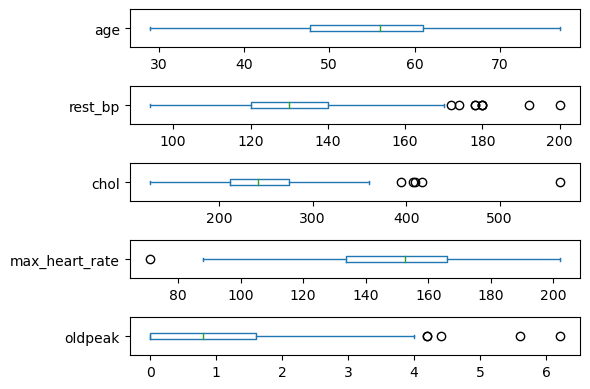

In [249]:
fig, ax = plt.subplots(5, 1, figsize=(6, 4))
df_num.plot.box(layout=(5, 1), 
            subplots=True, 
            ax=ax, 
            vert=False, 
            sharex=False)
plt.tight_layout()
plt.show()

### remove outliers (the dots/circles in the above boxplots)

In [250]:
columns = df_num.columns[1: ]

for i, col in enumerate(columns):
    q1 = np.quantile(df[col], 0.25)
    q3 = np.quantile(df[col], 0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    df = df.loc[(df[col]>lower) & (df[col]<upper)]

### the dataset's basic statistics after outlier removal

In [251]:
df.describe()

,age,sex,chest_pain,rest_bp,chol,fast_blood_sugar,rest_ecg,max_heart_rate,excs_ind_angina,oldpeak,slp,caa,thall,output
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,53.942029,0.699275,0.981884,129.278986,242.398551,0.137681,0.532609,150.086957,0.311594,0.932609,1.434783,0.699275,2.307971,0.565217
std,9.193886,0.459406,1.021424,14.786421,44.617981,0.345191,0.514186,22.857974,0.463986,1.003062,0.596432,0.987264,0.574686,0.496629
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,88.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,46.000000,0.000000,0.000000,120.000000,210.750000,0.000000,0.000000,132.750000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,54.500000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.600000,1.000000,0.000000,2.000000,1.000000
75%,60.000000,1.000000,2.000000,140.000000,270.250000,0.000000,1.000000,168.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,165.000000,360.000000,1.000000,2.000000,202.000000,1.000000,3.800000,2.000000,4.000000,3.000000,1.000000


### correlation matrix

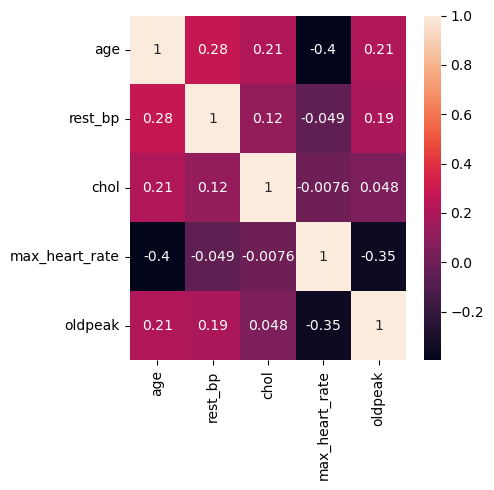

In [252]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.heatmap(df_num.corr(), annot = True, ax=ax)
plt.tight_layout()
plt.show()

## categorical features

In [253]:
df_cat = df.drop(['age', 'rest_bp', 'chol', 'max_heart_rate', 'oldpeak'], axis=1)
df_cat

,sex,chest_pain,fast_blood_sugar,rest_ecg,excs_ind_angina,slp,caa,thall,output
0,1,3,1,0,0,0,0,1,1
1,1,2,0,1,0,0,0,2,1
2,0,1,0,0,0,2,0,2,1
3,1,1,0,1,0,2,0,2,1
4,0,0,0,1,1,2,0,2,1
...,...,...,...,...,...,...,...,...,...
298,0,0,0,1,1,1,0,3,0
299,1,3,0,1,0,1,0,3,0
300,1,0,1,1,0,1,2,3,0
301,1,0,0,1,1,1,1,3,0


### countplots for each categorical features

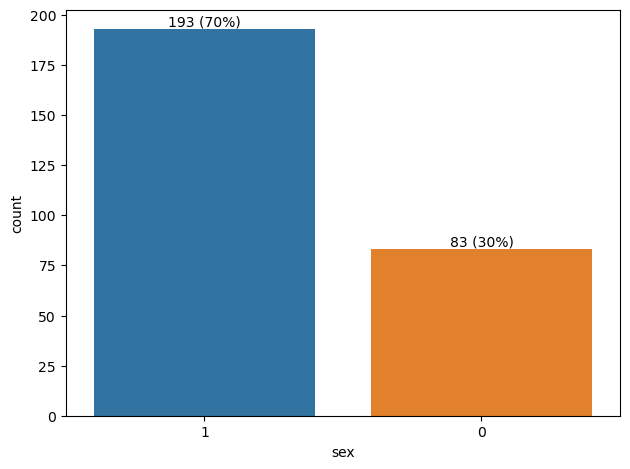

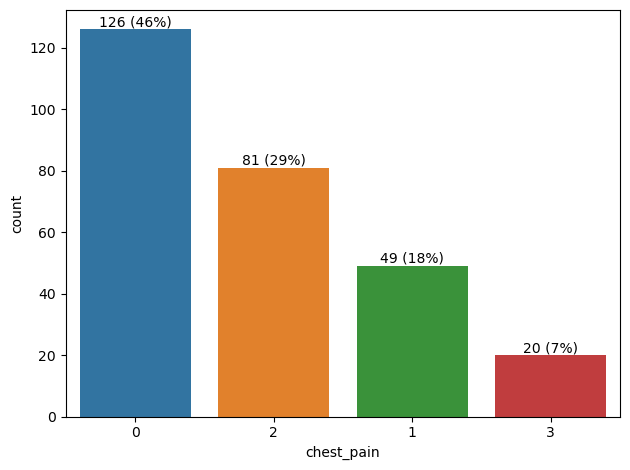

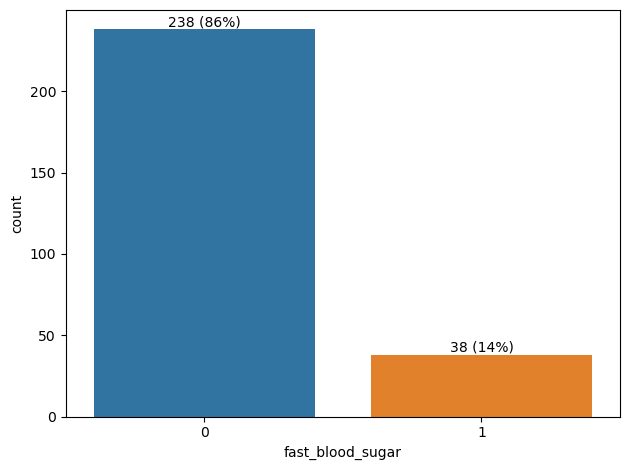

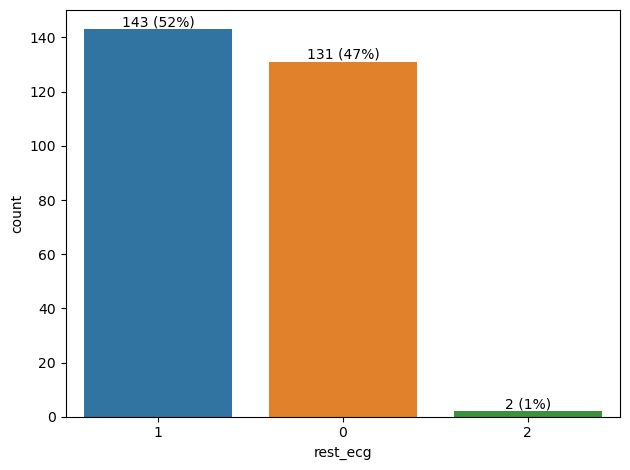

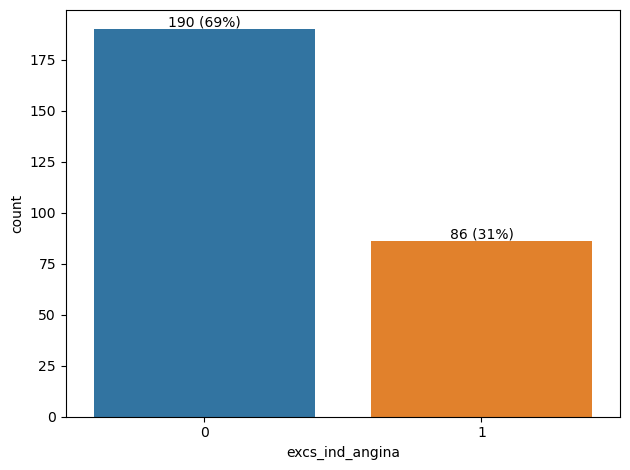

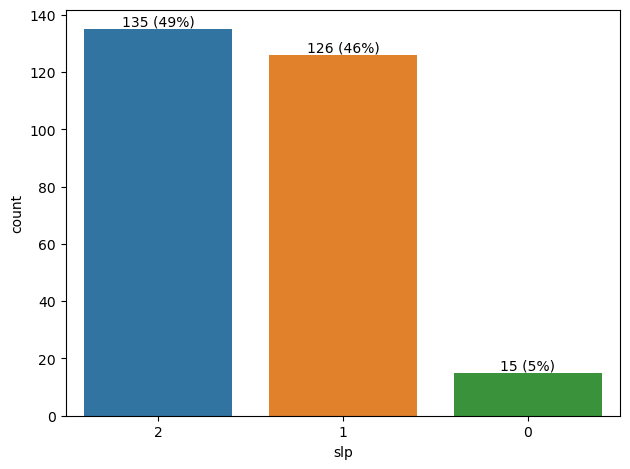

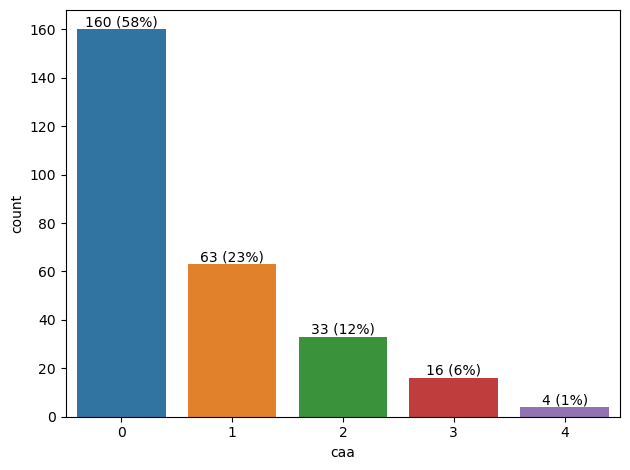

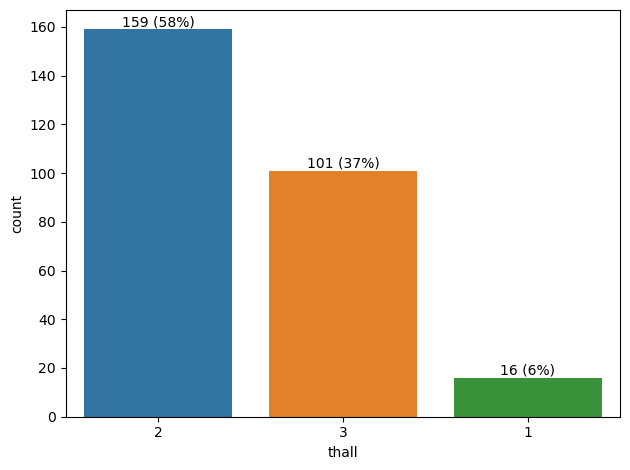

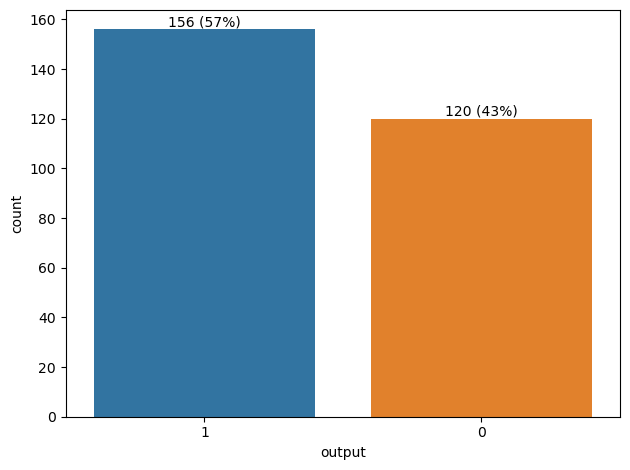

In [254]:
cat_cols = df_cat.columns

for i, col in enumerate(cat_cols):
    ax = sns.countplot(x=df[col], order=df[col].value_counts(ascending=False).index)
    abs_values = df[col].value_counts(ascending=False)
    rel_values = df[col].value_counts(ascending=False, normalize=True).values*100
    lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
    ax.bar_label(container=ax.containers[0], labels=lbls)
    plt.tight_layout()
    plt.show()  

### correlation matrix for categorical features using logistic regression

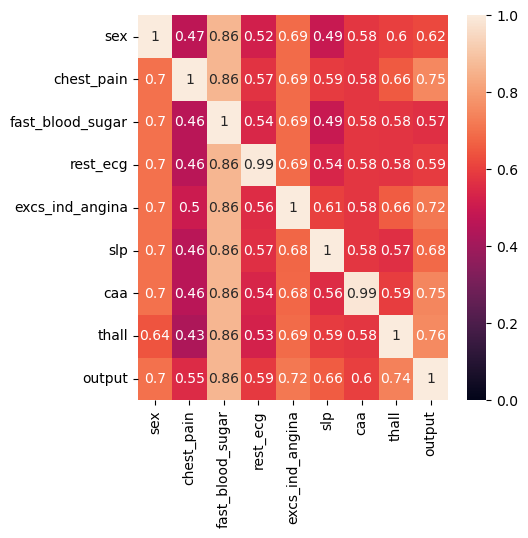

In [255]:
categorical_matrix_display(df_cat, cat_cols)

### correlation matrix for categorical features using cramer's V values

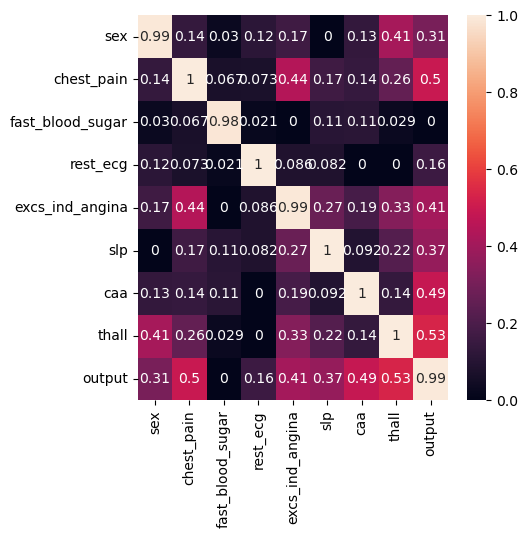

In [256]:
cramersVMatrix(df_cat, cat_cols)

# Separate features and target

## features

In [13]:
X = df.drop('output', axis=1)
X

,age,sex,chest_pain,rest_bp,chol,fast_blood_sugar,rest_ecg,max_heart_rate,excs_ind_angina,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


## target

In [14]:
y = df['output']
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: output, Length: 300, dtype: int64

# Train-test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Machine learning

## test which pipeline is better. different combination of estimator and scaler (min-max and standard scaler)

In [260]:
steps_logreg_mms = [('mms', MinMaxScaler()), 
                    ('logreg', LogisticRegression())]
steps_logreg_ss = [('ss', StandardScaler()), 
                   ('logreg', LogisticRegression())]

steps_dt_mms = [('mms', MinMaxScaler()), 
                ('dt', DecisionTreeClassifier())]
steps_dt_ss = [('ss', StandardScaler()), 
               ('dt', DecisionTreeClassifier())]

steps_rf_mms = [('mms', MinMaxScaler()), 
                ('rf', RandomForestClassifier())]
steps_rf_ss = [('ss', StandardScaler()), 
               ('rf', RandomForestClassifier())]

steps_knn_mms = [('mms', MinMaxScaler()), 
                ('knn', KNeighborsClassifier())]
steps_knn_ss = [('ss', StandardScaler()), 
                ('knn', KNeighborsClassifier())]
 
steps_svc_mms = [('mms', MinMaxScaler()), 
                 ('svc', LinearSVC())]
steps_svc_ss = [('ss', StandardScaler()), 
                ('svc', LinearSVC())]

best_score = 0.0

steps = [steps_logreg_mms, 
         steps_logreg_ss, 
         steps_dt_mms, 
         steps_dt_ss,
         steps_rf_mms, 
         steps_rf_ss,
         steps_knn_mms,
         steps_knn_ss,
         steps_svc_mms,
         steps_svc_ss]

for i, step in enumerate(steps):
    pipe = Pipeline(steps=step)
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    print(f'Pipe {i+1} accuracy score: {score}')

    if score > best_score:
        best_score = score
        best_pipe = pipe

print(f'Best pipe is {best_pipe} with accuracy score of {best_score}')

Pipe 1 accuracy score: 0.8214285714285714
Pipe 2 accuracy score: 0.8392857142857143
Pipe 3 accuracy score: 0.7678571428571429
Pipe 4 accuracy score: 0.7321428571428571
Pipe 5 accuracy score: 0.8571428571428571
Pipe 6 accuracy score: 0.8571428571428571
Pipe 7 accuracy score: 0.7857142857142857
Pipe 8 accuracy score: 0.7678571428571429
Pipe 9 accuracy score: 0.8392857142857143
Pipe 10 accuracy score: 0.8392857142857143
Best pipe is Pipeline(steps=[('mms', MinMaxScaler()), ('rf', RandomForestClassifier())]) with accuracy score of 0.8571428571428571


### so, best pipeline is Random Forest Classifier with accuracy score of 0.8571 (both Min-Max and Standard scaler gave the same accuracy)

## GridSearchCV using Random Forest Classifier as the estimator and min-max scaler

### create the gridsearch object

In [261]:
params = {'rf__n_estimators': [25, 50, 100, 200, 400],
          'rf__criterion': ['gini', 'entropy', 'log_loss'],
          'rf__bootstrap': [True, False],
          'rf__oob_score': [False, True],
          'rf__random_state': [None, 42]}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

grid_svc = GridSearchCV(estimator=best_pipe, param_grid=params, cv=kf, verbose=1)

### fitting

In [262]:
grid_svc.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
600 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    t

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('mms', MinMaxScaler()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__bootstrap': [True, False],
                         'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__n_estimators': [25, 50, 100, 200, 400],
                         'rf__oob_score': [False, True],
                         'rf__random_state': [None, 42]},
             verbose=1)

### best estimator

In [263]:
grid_svc.best_estimator_

Pipeline(steps=[('mms', MinMaxScaler()),
                ('rf',
                 RandomForestClassifier(criterion='entropy', oob_score=True))])

### best accuracy score

In [264]:
grid_svc.best_score_

0.8363636363636363

### best parameters

In [265]:
grid_svc.best_params_

{'rf__bootstrap': True,
 'rf__criterion': 'entropy',
 'rf__n_estimators': 100,
 'rf__oob_score': True,
 'rf__random_state': None}

### save the model (fitted GridSearchCV object)

In [266]:
MODEL_PATH = os.path.join(os.getcwd(), 'model', 'best_model_v2.pkl')
with open(MODEL_PATH, 'wb') as file:
    pickle.dump(grid_svc, file)

# Metrics

## classification report

In [267]:
y_pred = grid_svc.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=['lower heart attack chance', 'higher heart attack chance']))

                            precision    recall  f1-score   support

 lower heart attack chance       0.85      0.77      0.81        22
higher heart attack chance       0.86      0.91      0.89        34

                  accuracy                           0.86        56
                 macro avg       0.86      0.84      0.85        56
              weighted avg       0.86      0.86      0.86        56



## confusion matrix

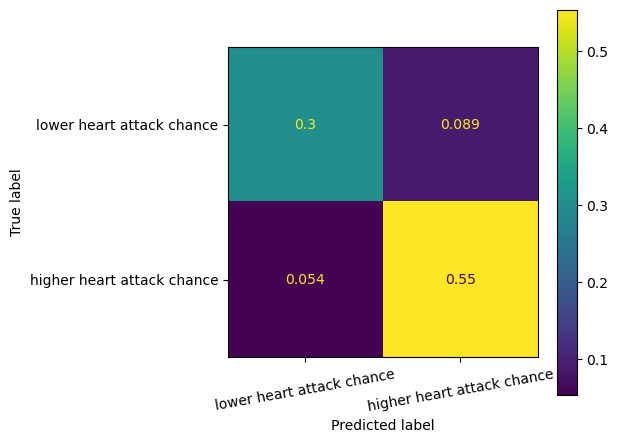

In [268]:
cm = confusion_matrix(y_test, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cmd.from_predictions(y_test, 
                     y_pred, 
                     normalize='all', 
                     ax=ax, 
                     display_labels=['lower heart attack chance', 'higher heart attack chance'],
                     xticks_rotation=10)

plt.show()